# Assignment 5

Explore embeddings and CNN

Using tweeter dataset ( https://www.kaggle.com/utathya/sentiment-analysis-of-imdb-reviews/data) and already existing splitting on train/test sets, develop a model for sentiment analysis.  
Your quality metric is crossentropy (`sklearn.metrics.log_loss`, `torch.nn.CrossEntropy`)  

Your model should be based on CNN and written in pytorch `torch.nn.Conv1d`.

Explore 3 ways, which of them has better perfomance on test set?:
1. Using pretrained word embeddings with frozen weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=True)`.
You can download any pretrained embeddings you like.
2. Train embeddings yourself, initializing from pretrained weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=False)`
3. Train embeddings yourself with random initialization `torch.nn.init.uniform_(nn.Embeddings.weights)`

Experiment with model arhitecture (as bonus):
1. activation functions RELU, ELU, etc `torch.nn.functional.relu, torch.nn.functional.elu`  
1. Stack layers
1. max or average pooling (`torch.nn.functional.max_pool1d, torch.nn.functional.avg_pool1d`)
1. Dropout


Other requirements:
1. Your training routine should use any learning scheduler (torch.nn.optim.lr_scheduler).  
Plot current learning rate against number of epochs, e.g. `tt.optim.Adam.param_groups[0]['lr']`.  

1. Your training routine should use early stopping on validation dataset
Use hold out validation scheme in your experiments.

1. You should use torchtext for parsing 

**Note**:
This assignment has no baseline. Instead, **validation curves** for explored architectures are expected.  
Validation curve is plot of model test score against model hyperparameter value.  
example (https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html) . 
Though, using `sklearn.model_selection.validation_curve` is not necessary.  






Импортируем все нужные библиотеки, поставим сиды и зададим размерность вектора эмбеддингов.

In [130]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
import nltk
import gensim
import spacy

from sklearn import metrics

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator



SEED = 42
EMBED_SIZE=300
np.random.seed(SEED)
tt.manual_seed(SEED);

Импортируем спейси для того, чтобы токенизировать наш датасет.

In [131]:
import spacy


spacy_en = spacy.load('en')

def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text) if tok.text.isalpha()]            

Создадим датасет с двумя полями с помощью torchtext, также уберём стопслова.

In [132]:
classes={
    'negative':0,
    'neutral':1,
    'positive':2
}

TEXT = Field(include_lengths=True, batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=nltk.corpus.stopwords.words('english'))
LABEL = LabelField(dtype=tt.int64, use_vocab=True, preprocessing=lambda x: classes[x])

dataset = TabularDataset('Tweets.csv', format='csv', 
                         fields=[(None, None),('label', LABEL), (None, None),(None, None),('text', TEXT)], 
                         skip_header=True)

Создадим словарь для текста, и словарь для лейблов. В тексте минимальная частота слова должна быть 5.

In [133]:
TEXT.build_vocab(dataset, min_freq=5)
LABEL.build_vocab(dataset)

Разделим датасет на три части.

In [134]:
train, test = dataset.split(0.7, stratified=True)
train, valid = train.split(0.7, stratified=True)

Загружаем предобученные векторы эмбеддингов.

In [135]:
wv_from_bin = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

Находим среди них только те, которые нам нужны в этом датасете (очевидно что в условиях реального полигона это нонсенс)

In [136]:
matrix_len = len(TEXT.vocab.itos)
weights_matrix = np.zeros((matrix_len, EMBED_SIZE))
words_found = 0

for i, word in enumerate(TEXT.vocab.itos):
    try: 
        weights_matrix[i] = wv_from_bin[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(EMBED_SIZE, ))
weights = tt.FloatTensor(weights_matrix)

Строим модель классификатора

In [137]:
class CNNSentimentClassifier(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size, kernels, weights=None, pretrained=False, freeze = False):
        super(CNNSentimentClassifier, self).__init__()
        if pretrained:
            self.embedding = nn.Embedding.from_pretrained(weights, freeze=freeze)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size)
            tt.nn.init.uniform_(self.embedding.weight)
            
        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        
    def forward(self, x):
        
        x = self.embedding(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        return x

Определяем класс, для раннего останова.

In [138]:
class EarlyStopping: # https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0



Задаем процесс обучения

In [139]:
from tqdm import tqdm_notebook as tqdm


def train_epoch(epoch_count, model):
    early_stopping = EarlyStopping(verbose=True)
    
    for epoch_idx in range(epoch_count):
        epoch_loss = 0
        model.train()
        for batch in tqdm(train_iterator):
            optimizer.zero_grad()
            text, labels = batch.text, batch.label
            prediction = model(text[0])
            loss = criterion(prediction, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.data * text[0].size(0)

        epoch_loss /= len(train)
        val_loss = 0
        model.eval()
        for batch in valid_iterator:
            text, labels = batch.text, batch.label
            prediction = model(text[0])
            loss = criterion(prediction, labels)
            val_loss += loss.data * text[0].size(0)
        val_loss /= len(valid)
        scheduler.step(val_loss)
        
        early_stopping(val_loss, model)
    
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch_idx, epoch_loss, val_loss))

Алгоритм тестирования.

In [140]:
def test_model(model):
    model.eval()
    test_loss = 0.
    for test_batch in test_iterator:
        text, labels = test_batch.text, test_batch.label
        prediction = model(text[0])
        loss = criterion(prediction, labels)
        test_loss += loss.data * text[0].size(0)
    test_loss /= len(test)
    print('Testing Loss: {:.4f}'.format(test_loss))

Определяем параметры для первой из трёх моделей -- с рандомными эмбеддингами.

In [141]:
batch_size = 32

cnn_random_init = CNNSentimentClassifier(len(TEXT.vocab.itos),
                embed_size=EMBED_SIZE,
                hidden_size=128,
                kernels=[2,3,4,5]
               )


train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.text),
#     sort_within_batch=True,
)

optimizer = optim.Adam(cnn_random_init.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, cooldown=5)
criterion = nn.CrossEntropyLoss()

Обучаем модель на 100 эпохах.

In [142]:
train_epoch(100, cnn_random_init)

Epoch: 0, Training Loss: 0.8712, Validation Loss: 0.9190


Epoch: 1, Training Loss: 0.8447, Validation Loss: 0.8918


EarlyStopping counter: 1 out of 7
Epoch: 2, Training Loss: 0.8320, Validation Loss: 0.9194


Epoch: 3, Training Loss: 0.8152, Validation Loss: 0.8735


Epoch: 4, Training Loss: 0.7924, Validation Loss: 0.8553


Epoch: 5, Training Loss: 0.7487, Validation Loss: 0.7248


Epoch: 6, Training Loss: 0.6969, Validation Loss: 0.6860


EarlyStopping counter: 1 out of 7
Epoch: 7, Training Loss: 0.6535, Validation Loss: 0.7008


Epoch: 8, Training Loss: 0.6071, Validation Loss: 0.6759


EarlyStopping counter: 1 out of 7
Epoch: 9, Training Loss: 0.5845, Validation Loss: 0.7299


Epoch: 10, Training Loss: 0.5588, Validation Loss: 0.6268


EarlyStopping counter: 1 out of 7
Epoch: 11, Training Loss: 0.5505, Validation Loss: 0.6342


EarlyStopping counter: 2 out of 7
Epoch: 12, Training Loss: 0.5252, Validation Loss: 0.6392


EarlyStopping counter: 3 out of 7
Epoch: 13, Training Loss: 0.5099, Validation Loss: 0.6877


EarlyStopping counter: 4 out of 7
Epoch: 14, Training Loss: 0.4977, Validation Loss: 0.7382


EarlyStopping counter: 5 out of 7
Epoch: 15, Training Loss: 0.4750, Validation Loss: 0.6967


Epoch    16: reducing learning rate of group 0 to 1.0000e-05.
EarlyStopping counter: 6 out of 7
Epoch: 16, Training Loss: 0.4618, Validation Loss: 0.6723


EarlyStopping counter: 7 out of 7
Early stopping


Далее вторая модель с замороженными, но претренированными весами. Переопределяем все важные элементы, такие как итератор, алгоритм оптимизации, алгоритм управляющий темпом обучения и лосс, потому что это НАДЕЖНЕЕ (есть информация что с этим есть проблемы иногда, это просто перестраховка).

In [143]:
cnn_pretrained_frozen = CNNSentimentClassifier(
                len(TEXT.vocab.itos),
                embed_size=300,
                hidden_size=128,
                kernels=[2,3,4,5],
                weights=weights,
                freeze=True,
                pretrained=True
               )

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.text),
#     sort_within_batch=True,
)

optimizer = optim.Adam(cnn_pretrained_frozen.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, cooldown=5)
criterion = nn.CrossEntropyLoss()

Её тоже тренируем на 100 эпохах.

In [144]:
train_epoch(100, cnn_pretrained_frozen)

Epoch: 0, Training Loss: 0.8932, Validation Loss: 1.0395


EarlyStopping counter: 1 out of 7
Epoch: 1, Training Loss: 0.8195, Validation Loss: 1.0483


Epoch: 2, Training Loss: 0.7946, Validation Loss: 0.9984


Epoch: 3, Training Loss: 0.7731, Validation Loss: 0.9053


Epoch: 4, Training Loss: 0.7422, Validation Loss: 0.8793


Epoch: 5, Training Loss: 0.7162, Validation Loss: 0.7831


Epoch: 6, Training Loss: 0.6903, Validation Loss: 0.7476


Epoch: 7, Training Loss: 0.6761, Validation Loss: 0.7049


Epoch: 8, Training Loss: 0.6561, Validation Loss: 0.6785


Epoch: 9, Training Loss: 0.6451, Validation Loss: 0.6557


Epoch: 10, Training Loss: 0.6370, Validation Loss: 0.6310


EarlyStopping counter: 1 out of 7
Epoch: 11, Training Loss: 0.6351, Validation Loss: 0.6316


EarlyStopping counter: 2 out of 7
Epoch: 12, Training Loss: 0.6269, Validation Loss: 0.6325


Epoch: 13, Training Loss: 0.6231, Validation Loss: 0.6285


EarlyStopping counter: 1 out of 7
Epoch: 14, Training Loss: 0.6206, Validation Loss: 0.6320


Epoch: 15, Training Loss: 0.6080, Validation Loss: 0.6268


Epoch: 16, Training Loss: 0.6097, Validation Loss: 0.6162


Epoch: 17, Training Loss: 0.6111, Validation Loss: 0.6149


Epoch: 18, Training Loss: 0.6052, Validation Loss: 0.6091


EarlyStopping counter: 1 out of 7
Epoch: 19, Training Loss: 0.6022, Validation Loss: 0.6164


EarlyStopping counter: 2 out of 7
Epoch: 20, Training Loss: 0.5960, Validation Loss: 0.6110


EarlyStopping counter: 3 out of 7
Epoch: 21, Training Loss: 0.5966, Validation Loss: 0.6106


Epoch: 22, Training Loss: 0.6035, Validation Loss: 0.6081


EarlyStopping counter: 1 out of 7
Epoch: 23, Training Loss: 0.5905, Validation Loss: 0.6148


EarlyStopping counter: 2 out of 7
Epoch: 24, Training Loss: 0.5940, Validation Loss: 0.6097


Epoch: 25, Training Loss: 0.5822, Validation Loss: 0.6052


Epoch: 26, Training Loss: 0.5868, Validation Loss: 0.6016


EarlyStopping counter: 1 out of 7
Epoch: 27, Training Loss: 0.5849, Validation Loss: 0.6145


EarlyStopping counter: 2 out of 7
Epoch: 28, Training Loss: 0.5892, Validation Loss: 0.6110


EarlyStopping counter: 3 out of 7
Epoch: 29, Training Loss: 0.5839, Validation Loss: 0.6017


EarlyStopping counter: 4 out of 7
Epoch: 30, Training Loss: 0.5786, Validation Loss: 0.6073


Epoch: 31, Training Loss: 0.5793, Validation Loss: 0.6008


EarlyStopping counter: 1 out of 7
Epoch: 32, Training Loss: 0.5743, Validation Loss: 0.6021


EarlyStopping counter: 2 out of 7
Epoch: 33, Training Loss: 0.5801, Validation Loss: 0.6040


EarlyStopping counter: 3 out of 7
Epoch: 34, Training Loss: 0.5694, Validation Loss: 0.6096


EarlyStopping counter: 4 out of 7
Epoch: 35, Training Loss: 0.5718, Validation Loss: 0.6042


EarlyStopping counter: 5 out of 7
Epoch: 36, Training Loss: 0.5722, Validation Loss: 0.6123


Epoch: 37, Training Loss: 0.5824, Validation Loss: 0.5988


EarlyStopping counter: 1 out of 7
Epoch: 38, Training Loss: 0.5724, Validation Loss: 0.6079


EarlyStopping counter: 2 out of 7
Epoch: 39, Training Loss: 0.5759, Validation Loss: 0.6086


Epoch: 40, Training Loss: 0.5726, Validation Loss: 0.5967


EarlyStopping counter: 1 out of 7
Epoch: 41, Training Loss: 0.5634, Validation Loss: 0.5984


EarlyStopping counter: 2 out of 7
Epoch: 42, Training Loss: 0.5741, Validation Loss: 0.6016


EarlyStopping counter: 3 out of 7
Epoch: 43, Training Loss: 0.5717, Validation Loss: 0.6022


EarlyStopping counter: 4 out of 7
Epoch: 44, Training Loss: 0.5741, Validation Loss: 0.6018


EarlyStopping counter: 5 out of 7
Epoch: 45, Training Loss: 0.5717, Validation Loss: 0.5998


Epoch    46: reducing learning rate of group 0 to 1.0000e-05.
EarlyStopping counter: 6 out of 7
Epoch: 46, Training Loss: 0.5629, Validation Loss: 0.5989


Epoch: 47, Training Loss: 0.5493, Validation Loss: 0.5957


EarlyStopping counter: 1 out of 7
Epoch: 48, Training Loss: 0.5465, Validation Loss: 0.5962


EarlyStopping counter: 2 out of 7
Epoch: 49, Training Loss: 0.5472, Validation Loss: 0.5966


EarlyStopping counter: 3 out of 7
Epoch: 50, Training Loss: 0.5469, Validation Loss: 0.5966


EarlyStopping counter: 4 out of 7
Epoch: 51, Training Loss: 0.5467, Validation Loss: 0.5967


EarlyStopping counter: 5 out of 7
Epoch: 52, Training Loss: 0.5456, Validation Loss: 0.5967


EarlyStopping counter: 6 out of 7
Epoch: 53, Training Loss: 0.5477, Validation Loss: 0.5976


EarlyStopping counter: 7 out of 7
Early stopping


Третья, и последняя модель с размороженными предобученными весами.

In [145]:
cnn_pretrained = CNNSentimentClassifier(len(TEXT.vocab.itos),
                embed_size=300,
                hidden_size=128,
                kernels=[2,3,4,5],
                weights=weights,
                freeze=False,
                pretrained=True
               )

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.text),
#     sort_within_batch=True,
)

optimizer = optim.Adam(cnn_pretrained.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, cooldown=5)
criterion = nn.CrossEntropyLoss()

Тренируем и её.

In [146]:
train_epoch(100, cnn_pretrained)

Epoch: 0, Training Loss: 0.8919, Validation Loss: 1.0279


Epoch: 1, Training Loss: 0.7976, Validation Loss: 1.0170


Epoch: 2, Training Loss: 0.7484, Validation Loss: 0.9243


Epoch: 3, Training Loss: 0.6911, Validation Loss: 0.7882


Epoch: 4, Training Loss: 0.6230, Validation Loss: 0.7304


Epoch: 5, Training Loss: 0.5692, Validation Loss: 0.6578


Epoch: 6, Training Loss: 0.5272, Validation Loss: 0.6314


Epoch: 7, Training Loss: 0.5004, Validation Loss: 0.6143


Epoch: 8, Training Loss: 0.4707, Validation Loss: 0.6034


Epoch: 9, Training Loss: 0.4505, Validation Loss: 0.6033


Epoch: 10, Training Loss: 0.4324, Validation Loss: 0.5971


EarlyStopping counter: 1 out of 7
Epoch: 11, Training Loss: 0.4221, Validation Loss: 0.6094


EarlyStopping counter: 2 out of 7
Epoch: 12, Training Loss: 0.4087, Validation Loss: 0.6144


EarlyStopping counter: 3 out of 7
Epoch: 13, Training Loss: 0.3985, Validation Loss: 0.6235


EarlyStopping counter: 4 out of 7
Epoch: 14, Training Loss: 0.3852, Validation Loss: 0.6391


EarlyStopping counter: 5 out of 7
Epoch: 15, Training Loss: 0.3735, Validation Loss: 0.6445


Epoch    16: reducing learning rate of group 0 to 1.0000e-05.
EarlyStopping counter: 6 out of 7
Epoch: 16, Training Loss: 0.3614, Validation Loss: 0.6565


EarlyStopping counter: 7 out of 7
Early stopping


Далее переходим к построению валидационных кривых. Думаю, что я просто построю три графика с зависимостью от количества эпох. В принципе для этого нужно немножко модифицировать процесс тренировки.

Подключим матплотлиб.

In [147]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

Вся разница в тренировочном процессе в том, что мы возвращаем результаты тренировочной и валидирующей выборки.

In [148]:
def get_train_epoch_loss_data(epoch_count, model):
    early_stopping = EarlyStopping(verbose=True)
    train_losses = []
    val_losses = []
    for epoch_idx in range(epoch_count):
        epoch_loss = 0
        model.train()
        for batch in tqdm(train_iterator):
            optimizer.zero_grad()
            text, labels = batch.text, batch.label
            prediction = model(text[0])
            loss = criterion(prediction, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.data * text[0].size(0)

        epoch_loss /= len(train)
        val_loss = 0
        model.eval()
        for batch in valid_iterator:
            text, labels = batch.text, batch.label
            prediction = model(text[0])
            loss = criterion(prediction, labels)
            val_loss += loss.data * text[0].size(0)
        val_loss /= len(valid)
        scheduler.step(val_loss)
        
        early_stopping(val_loss, model)
    
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch_idx, epoch_loss, val_loss))
        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
    return train_losses, val_losses

А, и опять переопределяем все параметры. Для безопасности. В принципе можно было сразу так делатЬ, но что-то я об этом не подумал.

In [158]:
matrix_len = len(TEXT.vocab.itos)
weights_matrix = np.zeros((matrix_len, EMBED_SIZE))
words_found = 0

for i, word in enumerate(TEXT.vocab.itos):
    try: 
        weights_matrix[i] = wv_from_bin[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(EMBED_SIZE, ))
weights = tt.FloatTensor(weights_matrix)

In [149]:
batch_size = 32

cnn_random_init = CNNSentimentClassifier(len(TEXT.vocab.itos),
                embed_size=EMBED_SIZE,
                hidden_size=128,
                kernels=[2,3,4,5]
               )


train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.text),
#     sort_within_batch=True,
)

optimizer = optim.Adam(cnn_random_init.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, cooldown=5)
criterion = nn.CrossEntropyLoss()

In [150]:
random_train_losses, random_val_losses = get_train_epoch_loss_data(100, cnn_random_init)

Epoch: 0, Training Loss: 0.8731, Validation Loss: 0.9196


Epoch: 1, Training Loss: 0.8444, Validation Loss: 0.8832


EarlyStopping counter: 1 out of 7
Epoch: 2, Training Loss: 0.8314, Validation Loss: 0.9127


Epoch: 3, Training Loss: 0.8142, Validation Loss: 0.8695


Epoch: 4, Training Loss: 0.7931, Validation Loss: 0.8409


Epoch: 5, Training Loss: 0.7502, Validation Loss: 0.7177


Epoch: 6, Training Loss: 0.7000, Validation Loss: 0.6823


EarlyStopping counter: 1 out of 7
Epoch: 7, Training Loss: 0.6552, Validation Loss: 0.6854


Epoch: 8, Training Loss: 0.6065, Validation Loss: 0.6544


EarlyStopping counter: 1 out of 7
Epoch: 9, Training Loss: 0.5798, Validation Loss: 0.7060


Epoch: 10, Training Loss: 0.5515, Validation Loss: 0.6281


Epoch: 11, Training Loss: 0.5411, Validation Loss: 0.6279


EarlyStopping counter: 1 out of 7
Epoch: 12, Training Loss: 0.5123, Validation Loss: 0.6440


EarlyStopping counter: 2 out of 7
Epoch: 13, Training Loss: 0.5013, Validation Loss: 0.6935


EarlyStopping counter: 3 out of 7
Epoch: 14, Training Loss: 0.4870, Validation Loss: 0.7388


EarlyStopping counter: 4 out of 7
Epoch: 15, Training Loss: 0.4674, Validation Loss: 0.6789


EarlyStopping counter: 5 out of 7
Epoch: 16, Training Loss: 0.4496, Validation Loss: 0.6907


Epoch    17: reducing learning rate of group 0 to 1.0000e-05.
EarlyStopping counter: 6 out of 7
Epoch: 17, Training Loss: 0.4343, Validation Loss: 0.6569


EarlyStopping counter: 7 out of 7
Early stopping


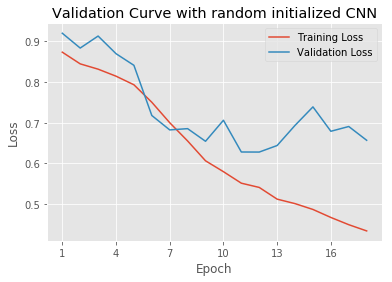

Testing Loss: 0.6919


In [151]:
plt.title("Validation Curve with random initialized CNN")
plt.xlabel("Epoch")
plt.ylabel("Loss")

x_ticks = range(1, len(random_train_losses) + 1)
plt.plot(x_ticks, random_train_losses, label="Training Loss")
plt.plot(x_ticks, random_val_losses, label="Validation Loss")
plt.xticks(range(1, len(x_ticks) + 1, 3))
plt.legend(loc="best")
plt.show()
test_model(cnn_random_init)

In [152]:
cnn_pretrained_frozen = CNNSentimentClassifier(
                len(TEXT.vocab.itos),
                embed_size=300,
                hidden_size=128,
                kernels=[2,3,4,5],
                weights=weights,
                freeze=True,
                pretrained=True
               )

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.text),
#     sort_within_batch=True,
)

optimizer = optim.Adam(cnn_pretrained_frozen.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, cooldown=5)
criterion = nn.CrossEntropyLoss()

In [153]:
pretrain_frozen_train_losses, pretrain_frozen_val_losses = get_train_epoch_loss_data(100, cnn_pretrained_frozen)

Epoch: 0, Training Loss: 0.8228, Validation Loss: 0.9404


Epoch: 1, Training Loss: 0.6527, Validation Loss: 0.8034


Epoch: 2, Training Loss: 0.5471, Validation Loss: 0.6646


Epoch: 3, Training Loss: 0.4718, Validation Loss: 0.6215


Epoch: 4, Training Loss: 0.4253, Validation Loss: 0.6185


EarlyStopping counter: 1 out of 7
Epoch: 5, Training Loss: 0.3933, Validation Loss: 0.6200


EarlyStopping counter: 2 out of 7
Epoch: 6, Training Loss: 0.3751, Validation Loss: 0.6275


EarlyStopping counter: 3 out of 7
Epoch: 7, Training Loss: 0.3670, Validation Loss: 0.6430


EarlyStopping counter: 4 out of 7
Epoch: 8, Training Loss: 0.3554, Validation Loss: 0.6459


EarlyStopping counter: 5 out of 7
Epoch: 9, Training Loss: 0.3507, Validation Loss: 0.6578


Epoch    10: reducing learning rate of group 0 to 1.0000e-05.
EarlyStopping counter: 6 out of 7
Epoch: 10, Training Loss: 0.3470, Validation Loss: 0.6618


EarlyStopping counter: 7 out of 7
Early stopping


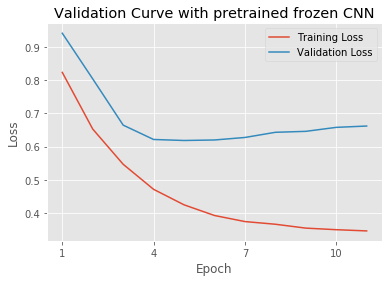

Testing Loss: 0.6854


In [154]:
plt.title("Validation Curve with pretrained frozen CNN")
plt.xlabel("Epoch")
plt.ylabel("Loss")

x_ticks = range(1, len(pretrain_frozen_train_losses) + 1)
plt.plot(x_ticks, pretrain_frozen_train_losses, label="Training Loss")
plt.plot(x_ticks, pretrain_frozen_val_losses, label="Validation Loss")
plt.xticks(range(1,  len(x_ticks) + 1, 3))
plt.legend(loc="best")
plt.show()
test_model(cnn_pretrained_frozen)

In [159]:
cnn_pretrained = CNNSentimentClassifier(len(TEXT.vocab.itos),
                embed_size=300,
                hidden_size=128,
                kernels=[2,3,4,5],
                weights=weights,
                freeze=False,
                pretrained=True
               )

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.text),
#     sort_within_batch=True,
)

optimizer = optim.Adam(cnn_pretrained.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, cooldown=5)
criterion = nn.CrossEntropyLoss()

In [160]:
pretrain_train_losses, pretrain_val_losses = get_train_epoch_loss_data(100, cnn_pretrained)

Epoch: 0, Training Loss: 0.8930, Validation Loss: 1.0666


Epoch: 1, Training Loss: 0.8027, Validation Loss: 1.0488


Epoch: 2, Training Loss: 0.7514, Validation Loss: 0.9271


Epoch: 3, Training Loss: 0.6900, Validation Loss: 0.7714


Epoch: 4, Training Loss: 0.6185, Validation Loss: 0.7141


Epoch: 5, Training Loss: 0.5645, Validation Loss: 0.6442


Epoch: 6, Training Loss: 0.5239, Validation Loss: 0.6134


Epoch: 7, Training Loss: 0.4956, Validation Loss: 0.5948


Epoch: 8, Training Loss: 0.4671, Validation Loss: 0.5889


Epoch: 9, Training Loss: 0.4463, Validation Loss: 0.5888


Epoch: 10, Training Loss: 0.4263, Validation Loss: 0.5877


EarlyStopping counter: 1 out of 7
Epoch: 11, Training Loss: 0.4158, Validation Loss: 0.5999


EarlyStopping counter: 2 out of 7
Epoch: 12, Training Loss: 0.4019, Validation Loss: 0.6213


EarlyStopping counter: 3 out of 7
Epoch: 13, Training Loss: 0.3927, Validation Loss: 0.6228


EarlyStopping counter: 4 out of 7
Epoch: 14, Training Loss: 0.3782, Validation Loss: 0.6372


EarlyStopping counter: 5 out of 7
Epoch: 15, Training Loss: 0.3670, Validation Loss: 0.6484


Epoch    16: reducing learning rate of group 0 to 1.0000e-05.
EarlyStopping counter: 6 out of 7
Epoch: 16, Training Loss: 0.3565, Validation Loss: 0.6643


EarlyStopping counter: 7 out of 7
Early stopping


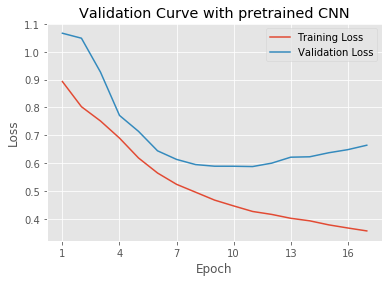

Testing Loss: 0.6737


In [161]:
plt.title("Validation Curve with pretrained CNN")
plt.xlabel("Epoch")
plt.ylabel("Loss")

x_ticks = range(1, len(pretrain_train_losses) + 1)
plt.plot(x_ticks, pretrain_train_losses, label="Training Loss")
plt.plot(x_ticks, pretrain_val_losses, label="Validation Loss")
plt.xticks(range(1, len(x_ticks) + 1, 3))
plt.legend(loc="best")
plt.show()
test_model(cnn_pretrained)